Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: generics


Attaching package: 'generics'


The following objects are masked from 'package:base':

    as.difftime, as.factor, as.ordered, intersect, is.element, setdiff,
    setequal, union



Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, saveRDS, table, tapply, unique,
    unsplit, which.max, which.min



Attaching package: 'S4Vectors'


The following object is masked from 'package:utils':

    findMatches


The follo

=== resultsNames ===
[1] "Intercept"                               
[2] "Treatment_Insulin.Resistant_vs_Control"  
[3] "Oxygen_Hypoxia_vs_Normoxia"              
[4] "TreatmentInsulin.Resistant.OxygenHypoxia"
=== dims (genes x samples) ===
[1] 18090    20
=== sample counts per group ===
                   
                    Normoxia Hypoxia
  Control                  5       5
  Insulin Resistant        5       5
=== size factors ===
GSM8773456 GSM8773457 GSM8773458 GSM8773459 GSM8773460 GSM8773461 GSM8773462 
 0.8695885  0.8285900  0.8469684  0.9242705  0.9039741  1.1562275  1.1261706 
GSM8773463 GSM8773464 GSM8773465 GSM8773466 GSM8773467 GSM8773468 GSM8773469 
 1.0663917  1.0176113  1.1019063  0.9708172  1.0913984  1.0781328  1.0238135 
GSM8773470 GSM8773471 GSM8773472 GSM8773473 GSM8773474 GSM8773475 
 1.0632385  0.9466506  1.0023464  0.9651701  1.1201618  1.1892726 


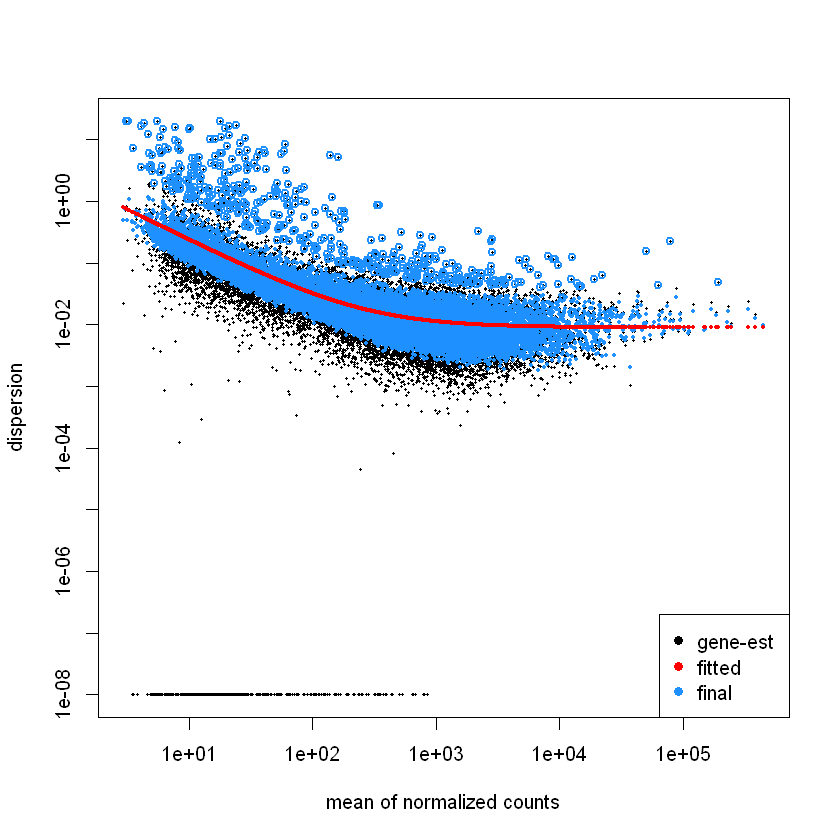

In [2]:
# PHASE 5: DEA


# 1) load libs & dds saved from Phase 4
library(DESeq2)
dds <- readRDS("../data/processed/dds_phase4_raw.rds")

# optional: reset factor reference levels if you want to be explicit
dds$Treatment <- relevel(dds$Treatment, ref = "Control")
dds$Oxygen    <- relevel(dds$Oxygen, ref = "Normoxia")
# ensure rownames of colData are sample names
rownames(colData(dds)) <- colData(dds)$Sample

# 2) (Recommended) register parallel backend if you have >1 core.
# On Linux/macOS:
# if (requireNamespace("BiocParallel", quietly=TRUE)) {
#   BiocParallel::register(BiocParallel::MulticoreParam(4))
# }
# On Windows use SnowParam:
# if (requireNamespace("BiocParallel", quietly=TRUE)) {
#   BiocParallel::register(BiocParallel::SnowParam(4))
# }

# 3) run DESeq (fit model)
dds <- DESeq(dds)   # set parallel=TRUE if you registered BiocParallel above

# 4) save fitted object
saveRDS(dds, "../data/processed/dds_phase5_fitted.rds")

# 5) basic diagnostics to print/send me
cat("=== resultsNames ===\n"); print(resultsNames(dds))
cat("=== dims (genes x samples) ===\n"); print(dim(dds))
cat("=== sample counts per group ===\n"); print(table(dds$Treatment, dds$Oxygen))
cat("=== size factors ===\n"); print(sizeFactors(dds))

# 6) quick dispersion plot (view in notebook)
plotDispEsts(dds)   # visually inspect; can save to file with png()/dev.off() if you like


In [3]:
# Ensure folder exists
dir.create("../results/qc", recursive = TRUE, showWarnings = FALSE)

# Save plotDispEsts() to file
png("../results/qc/dispersion_plot.png", width = 1200, height = 1000, res = 150)
plotDispEsts(dds)
dev.off()


agg_record_407913197 
                   2

In [4]:
cat("=== rds file ===\n"); print(head(dds),20)


=== rds file ===
<S4 Type Object>
attr(,"design")
~Treatment * Oxygen
attr(,"dispersionFunction")
function (q) 
coefs[1] + coefs[2]/q
<bytecode: 0x000001f2ded47668>
<environment: 0x000001f2ded47cc0>
attr(,"dispersionFunction")attr(,"coefficients")
              asymptDisp                extraPois 
0.0089597864500543019511 2.3158087295148996886951 
attr(,"dispersionFunction")attr(,"fitType")
[1] "parametric"
attr(,"dispersionFunction")attr(,"varLogDispEsts")
[1] 0.53100757655217001307
attr(,"dispersionFunction")attr(,"dispPriorVar")
[1] 0.39787056185813862719
attr(,"rowRanges")
GRangesList object of length 6:
$A1BG
GRanges object with 0 ranges and 0 metadata columns:
   seqnames    ranges strand
      <Rle> <IRanges>  <Rle>
  -------
  seqinfo: no sequences

$`A1BG-AS1`
GRanges object with 0 ranges and 0 metadata columns:
   seqnames    ranges strand
      <Rle> <IRanges>  <Rle>
  -------
  seqinfo: no sequences

$A2M
GRanges object with 0 ranges and 0 metadata columns:
   seqnames    r

In [ ]:
#Step 2 — Extract contrasts, shrink LFCs, save tables & QC plots

# 0) prepare directories & load object

library(DESeq2)
library(ggplot2)
library(pheatmap)
# optional: if you want nicer shrinkage
if (!requireNamespace("apeglm", quietly = TRUE)) {
  message("apeglm not found; install via BiocManager::install('apeglm') for better LFC shrinkage.")
}
dir.create("../results/DE", recursive = TRUE, showWarnings = FALSE)

dds <- readRDS("../data/processed/dds_phase5_fitted.rds")  # your fitted DESeqDataSet
resultsNames(dds) #sanity-check

[1] "Intercept"                               
[2] "Treatment_Insulin.Resistant_vs_Control"  
[3] "Oxygen_Hypoxia_vs_Normoxia"              
[4] "TreatmentInsulin.Resistant.OxygenHypoxia"

In [ ]:
# 1) Extract main-effect results (Treatment and Oxygen) with shrunken LFCs


# 1A: Treatment main effect (effect of Insulin Resistant vs Control, at reference oxygen)
res_treat <- results(dds, name = "Treatment_Insulin.Resistant_vs_Control", alpha = 0.05)
# shrink LFC with apeglm if available
if (requireNamespace("apeglm", quietly = TRUE)) {
  res_treat_shr <- lfcShrink(dds, coef = "Treatment_Insulin.Resistant_vs_Control", type = "apeglm")
} else {
  res_treat_shr <- lfcShrink(dds, coef = "Treatment_Insulin.Resistant_vs_Control", type = "normal")
}

# 1B: Oxygen main effect (Hypoxia vs Normoxia, in Control background)
res_oxy <- results(dds, name = "Oxygen_Hypoxia_vs_Normoxia", alpha = 0.05)
if (requireNamespace("apeglm", quietly = TRUE)) {
  res_oxy_shr <- lfcShrink(dds, coef = "Oxygen_Hypoxia_vs_Normoxia", type = "apeglm")
} else {
  res_oxy_shr <- lfcShrink(dds, coef = "Oxygen_Hypoxia_vs_Normoxia", type = "normal")
}


using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895

